In [10]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os
import re
from sklearn.model_selection import cross_val_score  #交叉验证
from sklearn.svm import SVC  #支持向量机
from sklearn.metrics import accuracy_score  #混淆矩阵准确度
from sklearn.metrics import classification_report  #混淆矩阵分类性能评估报告
from sklearn.metrics import confusion_matrix    #混淆矩阵数组

## 说明：
本程序为SVM分类器进行年龄分类任务

1. 对不均衡样本的分类器性能评估指标的选择实验、特殊采样处理的必要性实验

2. 使用非线性核函数SVM分类器，分别选用dlib库128维特征距离数据集、LBP图像PCA降维数据集做测试

## 导入数据集

In [35]:
trainDistance = np.load("data/trainDistance.npy")
testDistance = np.load("data/testDistance.npy")
DS_sex_map = np.load("data/DS_sex_map.npy")
DR_sex_map = np.load("data/DR_sex_map.npy")
DS_age_map = np.load("data/DS_age_map.npy")
DR_age_map = np.load("data/DR_age_map.npy")
DS_sex = np.load("data/DS_sex.npy",allow_pickle=True)
DR_sex = np.load("data/DR_sex.npy",allow_pickle=True)
DS_age = np.load("data/DS_age.npy",allow_pickle=True)
DR_age = np.load("data/DR_age.npy",allow_pickle=True)
print("DR_sex_map: ", DR_sex_map)
print("DS_sex_map: ", DS_sex_map)
print("DR_age_map: ", DR_age_map)
print("DS_age_map: ", DS_age_map)
print("DR_sex: ", DR_sex)
print("DS_sex: ", DS_sex)
print("DR_age: ", DR_age)
print("DS_age: ", DS_age)

DR_sex_map:  [1 1 1 ... 0 0 0]
DS_sex_map:  [0 0 1 ... 0 0 0]
DR_age_map:  [0 0 0 ... 2 3 3]
DS_age_map:  [3 2 3 ... 2 2 2]
DR_sex:  ['male' 'male' 'male' ... 'female' 'female' 'female']
DS_sex:  ['female' 'female' 'male' ... 'female' 'female' 'female']
DR_age:  ['child' 'child' 'child' ... 'adult' 'senior' 'senior']
DS_age:  ['senior' 'adult' 'senior' ... 'adult' 'adult' 'adult']


## 1.OVO LinearSVC

### 1.1 以一对一线性核SVM为例子，探究不均衡样本age直接使用时，分类器分类情况以及性能评估指标选择

#### 1)训练一代一对一线性核SVM分类器clf_ovoLinear，该模型没有加入惩罚因子调参

In [4]:
#采用sklearn.svm.SVC，类似的有sklearn.svm.LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

clf_ovoLinear = SVC(kernel='linear',decision_function_shape='ovo')
clf_ovoLinear.fit(trainDistance, DR_age)

SVC(decision_function_shape='ovo', kernel='linear')

#### 2)采用accuracy、precision、recall、F1四种性能评估指标对分类器性能进行初步分析

In [5]:
from sklearn.metrics import accuracy_score
ovoLinear_age_pre = clf_ovoLinear.predict(testDistance)
ovoLinear_accuracy = accuracy_score(DS_age, ovoLinear_age_pre)
print('ovoLinear_accuracy = ', ovoLinear_accuracy)
print('分类结果报告：', '\n', classification_report(DS_age, ovoLinear_age_pre))

ovoLinear_accuracy =  0.8862725450901804
分类结果报告： 
               precision    recall  f1-score   support

       adult       0.91      0.99      0.95      1730
       child       0.62      0.63      0.63        68
      senior       0.00      0.00      0.00       115
        teen       0.39      0.20      0.27        83

    accuracy                           0.89      1996
   macro avg       0.48      0.46      0.46      1996
weighted avg       0.82      0.89      0.85      1996



C:\Users\Rama\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rama\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rama\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


仅由accuracy会导致“分类器分类准确率达到0.89”的结果，然而由其他三种分类性能评估指标反映的分类器性能缺截然不同。

由上面的分类结果报告可以看出，只有adult标签在分类中得到了较好的结果，查全率recall达到了0.99、查准率precision = 0.91稍差，推测错分为adult的样本较多；由于adult的样本占据绝对数量优势，推测错分为adult的概率会极大地影响分类器性能。<br/>
adult以外的样本的分类性能惨不忍睹，就precision有：child = 0.62，senior = 0.0， teen = 0.39；recall有：child = 0.63， senior = 0.0, teen = 0.20。senior甚至全部错分！<br/>
如此低的分数反映出数据量的不均衡导致分类器性能极差，并且分类器的accuracy并不能反映出数据量的不均衡引起的分类器性能差异，必须使用precision、recall以及前两者的调和平均数f1-score才能真正反映不均衡样本训练出的分类器性能。

#### 3) 采用混淆矩阵观察样本的错分情况：

In [6]:
cfm_ovoLinear = confusion_matrix(DS_age, ovoLinear_age_pre)
print('ovoLinear混淆矩阵如下：\n')

ovoLinear混淆矩阵如下：



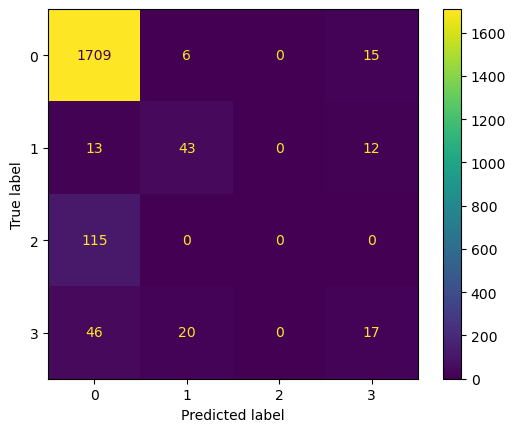

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay
cfm_ovoLinear_display = ConfusionMatrixDisplay(cfm_ovoLinear).plot()

上图中0 = adult， 1 = child， 2 = senior， 3 = teen

混淆矩阵结果分析：<br/>
1. child中有19.1%错分为adult，0%错分为senior，17.6%错分为teen<br/>
2. senior全部错分为adult<br/>
3. teen有55.4%错分为adult，24.1%错分为child，0%错分为senior

## 2. 非线性核函数SVM+SMOTE过采样处理数据集进行年龄分类任务

使用rbf核SVM与未采样处理数据集初步

In [18]:
from sklearn.svm import SVC
clf_rbf = SVC(kernel='rbf')
clf_rbf.fit(trainDistance, DR_age)

SVC()

In [19]:
rbf_age_pre = clf_rbf.predict(testDistance)
rbf_accuracy = accuracy_score(DS_age, rbf_age_pre)
print('rbf_accuracy = ', rbf_accuracy)
print('分类结果报告：', '\n', classification_report(DS_age, rbf_age_pre))

rbf_accuracy =  0.8867735470941884
分类结果报告： 
               precision    recall  f1-score   support

       adult       0.91      0.99      0.95      1730
       child       0.64      0.62      0.63        68
      senior       0.00      0.00      0.00       115
        teen       0.39      0.19      0.26        83

    accuracy                           0.89      1996
   macro avg       0.48      0.45      0.46      1996
weighted avg       0.82      0.89      0.85      1996



C:\Users\Rama\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rama\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rama\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 2.1 使用dlib库128维特征距离数据集

网格搜索法搜索最优参数

指标：f1_micro

In [13]:
from sklearn.model_selection import GridSearchCV

# Set the parameters by cross-validation
rbf_para = [{'kernel': ['rbf', 'poly', 'sigmoid'], 'C': [1, 100, 1000], 'gamma' : [1e-1, 1e-2, 1e-3], 'decision_function_shape':['ovo', 'ovr']}]

rbf_scores = ['f1_micro']

for score in rbf_scores:
    print("超参调节的评估标准为 %s" % score)
    print()

    rbfclf = GridSearchCV(
        SVC(), rbf_para, scoring='%s' % score
    )
    rbfclf.fit(trainDistance, DR_age)

    print("最佳参数为:", rbfclf.best_params_)
    print()
    
    print("在搜索范围内，对应参数的分类准确度如下：")
    means = rbfclf.cv_results_['mean_test_score']
    stds = rbfclf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, rbfclf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        
        
    print()
    
    rbfclf_age_pred = rbfclf.predict(testDistance)
    print('最佳参数分类器的分类结果报告：')
    print(classification_report(DS_age, rbfclf_age_pred))

超参调节的评估标准为 f1_micro

最佳参数为: {'C': 100, 'decision_function_shape': 'ovo', 'gamma': 0.01, 'kernel': 'sigmoid'}

在搜索范围内，对应参数的分类准确度如下：
0.762 (+/-0.035) for {'C': 1, 'decision_function_shape': 'ovo', 'gamma': 0.1, 'kernel': 'rbf'}
0.720 (+/-0.002) for {'C': 1, 'decision_function_shape': 'ovo', 'gamma': 0.1, 'kernel': 'poly'}
0.720 (+/-0.002) for {'C': 1, 'decision_function_shape': 'ovo', 'gamma': 0.1, 'kernel': 'sigmoid'}
0.720 (+/-0.002) for {'C': 1, 'decision_function_shape': 'ovo', 'gamma': 0.01, 'kernel': 'rbf'}
0.720 (+/-0.002) for {'C': 1, 'decision_function_shape': 'ovo', 'gamma': 0.01, 'kernel': 'poly'}
0.720 (+/-0.002) for {'C': 1, 'decision_function_shape': 'ovo', 'gamma': 0.01, 'kernel': 'sigmoid'}
0.720 (+/-0.002) for {'C': 1, 'decision_function_shape': 'ovo', 'gamma': 0.001, 'kernel': 'rbf'}
0.720 (+/-0.002) for {'C': 1, 'decision_function_shape': 'ovo', 'gamma': 0.001, 'kernel': 'poly'}
0.720 (+/-0.002) for {'C': 1, 'decision_function_shape': 'ovo', 'gamma': 0.001, 'kernel': '

C:\Users\Rama\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rama\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rama\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 2.2 使用LBP图像PCA降维数据集

指标：f1_macro

In [14]:
from sklearn.model_selection import GridSearchCV

# Set the parameters by cross-validation
rbf_para = [{'kernel': ['rbf', 'poly', 'sigmoid'], 'C': [1, 100, 1000], 'gamma' : [1e-1, 1e-2, 1e-3], 'decision_function_shape':['ovo', 'ovr']}]

rbf_scores = ['f1_macro']

for score in rbf_scores:
    print("超参调节的评估标准为 %s" % score)
    print()

    rbfclf = GridSearchCV(
        SVC(), rbf_para, scoring='%s' % score
    )
    rbfclf.fit(trainDistance, DR_age)

    print("最佳参数为:", rbfclf.best_params_)
    print()
    
    print("在搜索范围内，对应参数的分类准确度如下：")
    means = rbfclf.cv_results_['mean_test_score']
    stds = rbfclf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, rbfclf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        
        
    print()
    
    rbfclf_age_pred = rbfclf.predict(testDistance)
    print('最佳参数分类器的分类结果报告：')
    print(classification_report(DS_age, rbfclf_age_pred))

超参调节的评估标准为 f1_macro

最佳参数为: {'C': 1000, 'decision_function_shape': 'ovo', 'gamma': 0.1, 'kernel': 'poly'}

在搜索范围内，对应参数的分类准确度如下：
0.333 (+/-0.059) for {'C': 1, 'decision_function_shape': 'ovo', 'gamma': 0.1, 'kernel': 'rbf'}
0.209 (+/-0.000) for {'C': 1, 'decision_function_shape': 'ovo', 'gamma': 0.1, 'kernel': 'poly'}
0.209 (+/-0.000) for {'C': 1, 'decision_function_shape': 'ovo', 'gamma': 0.1, 'kernel': 'sigmoid'}
0.209 (+/-0.000) for {'C': 1, 'decision_function_shape': 'ovo', 'gamma': 0.01, 'kernel': 'rbf'}
0.209 (+/-0.000) for {'C': 1, 'decision_function_shape': 'ovo', 'gamma': 0.01, 'kernel': 'poly'}
0.209 (+/-0.000) for {'C': 1, 'decision_function_shape': 'ovo', 'gamma': 0.01, 'kernel': 'sigmoid'}
0.209 (+/-0.000) for {'C': 1, 'decision_function_shape': 'ovo', 'gamma': 0.001, 'kernel': 'rbf'}
0.209 (+/-0.000) for {'C': 1, 'decision_function_shape': 'ovo', 'gamma': 0.001, 'kernel': 'poly'}
0.209 (+/-0.000) for {'C': 1, 'decision_function_shape': 'ovo', 'gamma': 0.001, 'kernel': 'sig

In [15]:
rbf_age_pre = rbfclf.predict(testDistance)
rbf_age_accuracy = accuracy_score(DS_age, rbf_age_pre)
print('rbf_age_accuracy = ', rbf_age_accuracy)

rbf_age_accuracy =  0.8987975951903807


ovoLinear混淆矩阵如下：



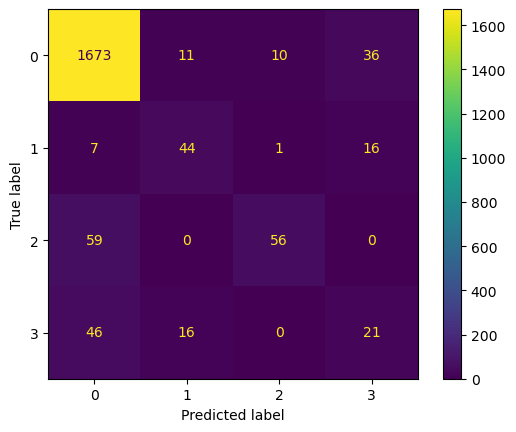

In [16]:
cfm_rbf = confusion_matrix(DS_age, rbf_age_pre)
print('ovoLinear混淆矩阵如下：\n')
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay(cfm_rbf).plot()

六折交叉验证

In [34]:
from sklearn.model_selection import cross_val_score
X = np.vstack((trainDistance,testDistance))
y = np.hstack((DR_age, DS_age))
# clf_best = SVC(kernel='sigmoid', C=1000, gamma=1e-2, decision_function_shape='ovo')
# clf_best = SVC(kernel='rbf', C=100, gamma=1e-2, decision_function_shape='ovo')
clf_best = SVC(kernel='poly', C=1000, gamma=1e-1, decision_function_shape='ovo')
scores_best = cross_val_score(clf_best, X, y, cv=6, scoring='f1_macro')
print('scores = ',scores_best)
print("f1_macro = %0.2f (+/- %0.2f)" % (scores_best.mean(), scores_best.std() * 2))

scores =  [0.60329185 0.65589654 0.63573476 0.75268538 0.67162145 0.68207886]
f1_macro = 0.67 (+/- 0.09)
